# Выбор локации для скважины


Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.

где, id — уникальный идентификатор скважины; f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы); product — объём запасов в скважине (тыс. баррелей).


In [1]:
!pip install phik -q

In [2]:
!pip install shap -q

In [3]:
!pip install --upgrade scikit-learn==1.2 -q

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import phik

from numpy.random import RandomState

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from plotly.subplots import make_subplots

from scipy import stats as st
from scipy.stats import binom, poisson
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression

# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score, make_scorer
# from sklearn.metrics import recall_score, precision_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix

from sklearn.datasets import  make_classification
from sklearn.inspection import permutation_importance

## Загрузка и подготовка данных

###  Загрузка и предобработка данных

In [5]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [6]:
def check_data(name):
    print('общая информация ***************************************************************************************************')
    name.info()
    print('первые 5 строк *****************************************************************************************************')
    display(name.head())
    print('название столбцов **************************************************************************************************')
    display(name.columns)
    print('количество пропусков ***********************************************************************************************')
    print(name.isnull().sum())
    print('количество явных дубликатов ********************************************************************************************')
    print(name.duplicated().sum())
    display(name.describe().T)

In [7]:
check_data(geo_data_0)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
первые 5 строк *****************************************************************************************************


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


название столбцов **************************************************************************************************


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

количество пропусков ***********************************************************************************************
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
количество явных дубликатов ********************************************************************************************
0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [8]:
check_data(geo_data_1)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
первые 5 строк *****************************************************************************************************


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


название столбцов **************************************************************************************************


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

количество пропусков ***********************************************************************************************
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
количество явных дубликатов ********************************************************************************************
0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [9]:
check_data(geo_data_2)

общая информация ***************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
первые 5 строк *****************************************************************************************************


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


название столбцов **************************************************************************************************


Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

количество пропусков ***********************************************************************************************
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
количество явных дубликатов ********************************************************************************************
0


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Вывод 1.1:
- данные загружены 
- пропусков не обнаружено 
- дубликатов не обнаружено
- названия столбцов не искажены
- данные соответствуют указанным типам 

###  Исследовательский анализ данных

In [10]:
def stat(DATA):
    display(DATA.describe().T)
    DATA.drop('id', axis=1).hist(figsize=(10, 7))

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


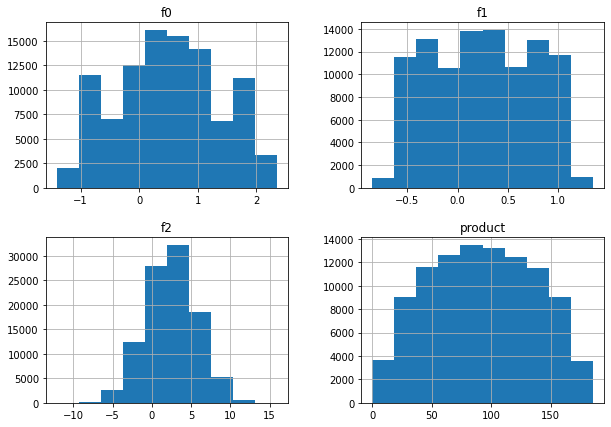

In [11]:
stat(geo_data_0)

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


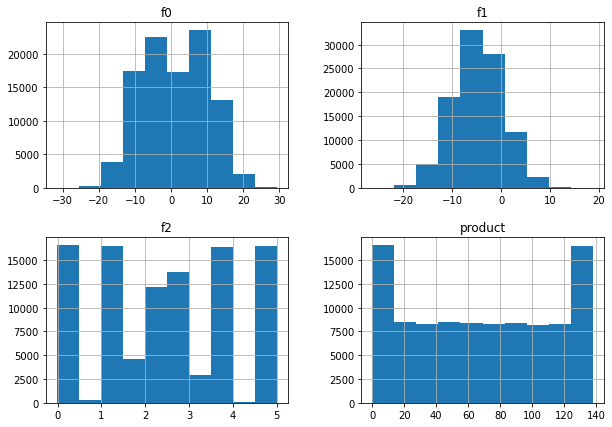

In [12]:
stat(geo_data_1)

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


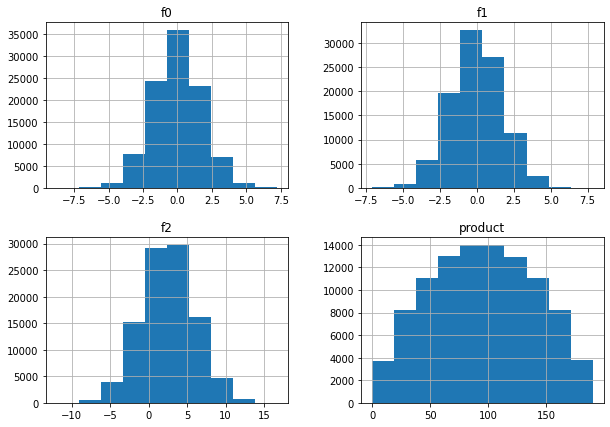

In [13]:
stat(geo_data_2)

In [14]:
def bxplt(DATA, name):
    sns.boxplot(data = DATA, y = name)
    plt.ylabel(name)
    plt.title('Ящик с усами')

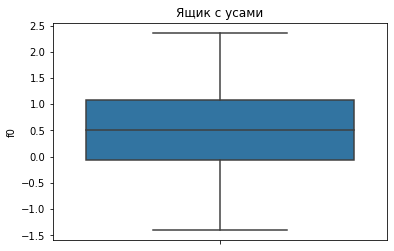

In [15]:
bxplt(geo_data_0, 'f0')

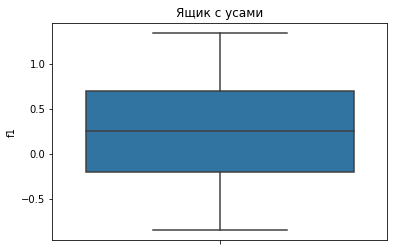

In [16]:
bxplt(geo_data_0, 'f1')

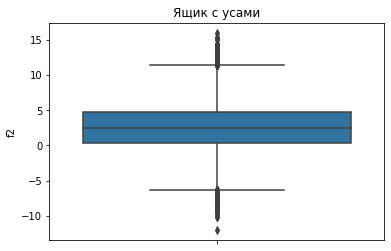

In [17]:
bxplt(geo_data_0, 'f2')

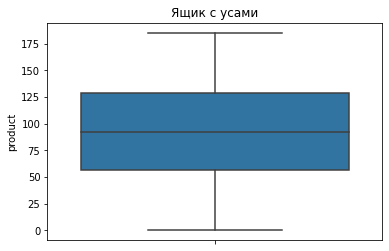

In [18]:
bxplt(geo_data_0, 'product')

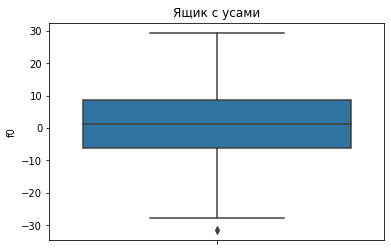

In [19]:
bxplt(geo_data_1, 'f0')

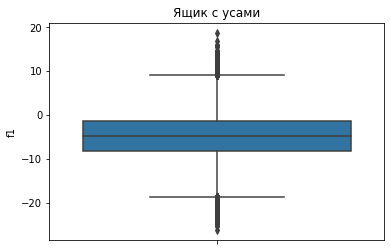

In [20]:
bxplt(geo_data_1, 'f1')

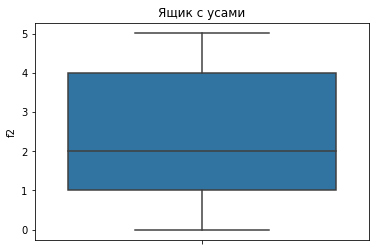

In [21]:
bxplt(geo_data_1, 'f2')

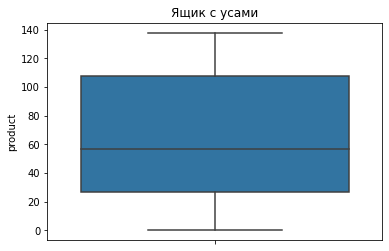

In [22]:
bxplt(geo_data_1, 'product')

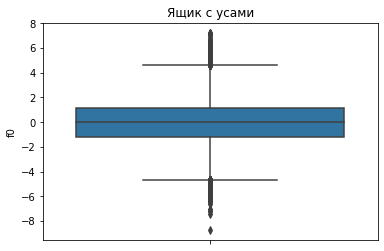

In [23]:
bxplt(geo_data_2, 'f0')

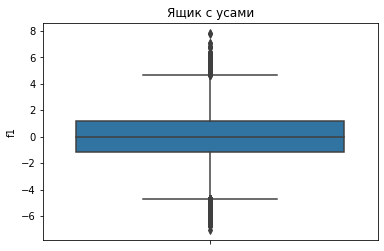

In [24]:
bxplt(geo_data_2, 'f1')

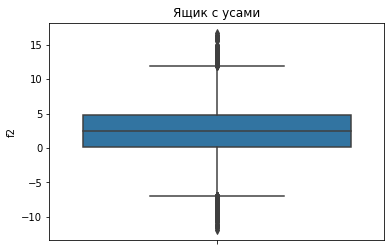

In [25]:
bxplt(geo_data_2, 'f2')

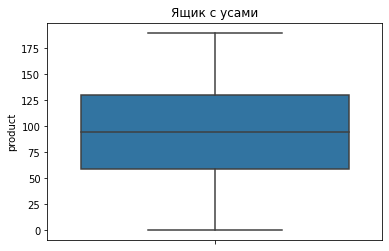

In [26]:
bxplt(geo_data_2, 'product')

Есть выбросы, выясним какое их количсетво и по необходимости избавимся от них

In [27]:
print(f'Процент выбросов в признаке "f2" в таблице geo_data_0 : {(len(geo_data_0.query("f2 > 10 | f2 < -5")) / len(geo_data_0) * 100)}%')
print(f'Процент выбросов в признаке "f0" в таблице geo_data_1 : {(len(geo_data_1.query("f0 < -30")) / len(geo_data_1) * 100)}%')
print(f'Процент выбросов в признаке "f1" в таблице geo_data_1 : {(len(geo_data_1.query("f1 >= 10 | f1 <= -20")) / len(geo_data_1) * 100)}%')
print(f'Процент выбросов в признаке "f0" в таблице geo_data_2: {(len(geo_data_2.query("f0 > 4| f0 < -4")) / len(geo_data_2) * 100)}%')
print(f'Процент выбросов в признаке "f1" в таблице geo_data_2: {(len(geo_data_2.query("f1 > 4| f1 < -4")) / len(geo_data_2) * 100)}%')
print(f'Процент выбросов в признаке "f2" в таблице geo_data_2: {(len(geo_data_2.query("f2 > 10| f2 < -5")) / len(geo_data_2) * 100)}%')

Процент выбросов в признаке "f2" в таблице geo_data_0 : 1.9539999999999997%
Процент выбросов в признаке "f0" в таблице geo_data_1 : 0.001%
Процент выбросов в признаке "f1" в таблице geo_data_1 : 0.327%
Процент выбросов в признаке "f0" в таблице geo_data_2: 2.125%
Процент выбросов в признаке "f1" в таблице geo_data_2: 2.038%
Процент выбросов в признаке "f2" в таблице geo_data_2: 2.9819999999999998%


Так как проценты выбросов малы и поэтому их влияние незначительно, то их можно оставить

### Корелляционный анализ

Проведем корреляционный анализ и проверем признаки на мультиколлениарность

In [28]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['f0', 'f1', 'f2', 'product']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(geo_data_0.set_index('id'),interval_cols=interval_cols)
print(phik_overview.shape) 

(4, 4)


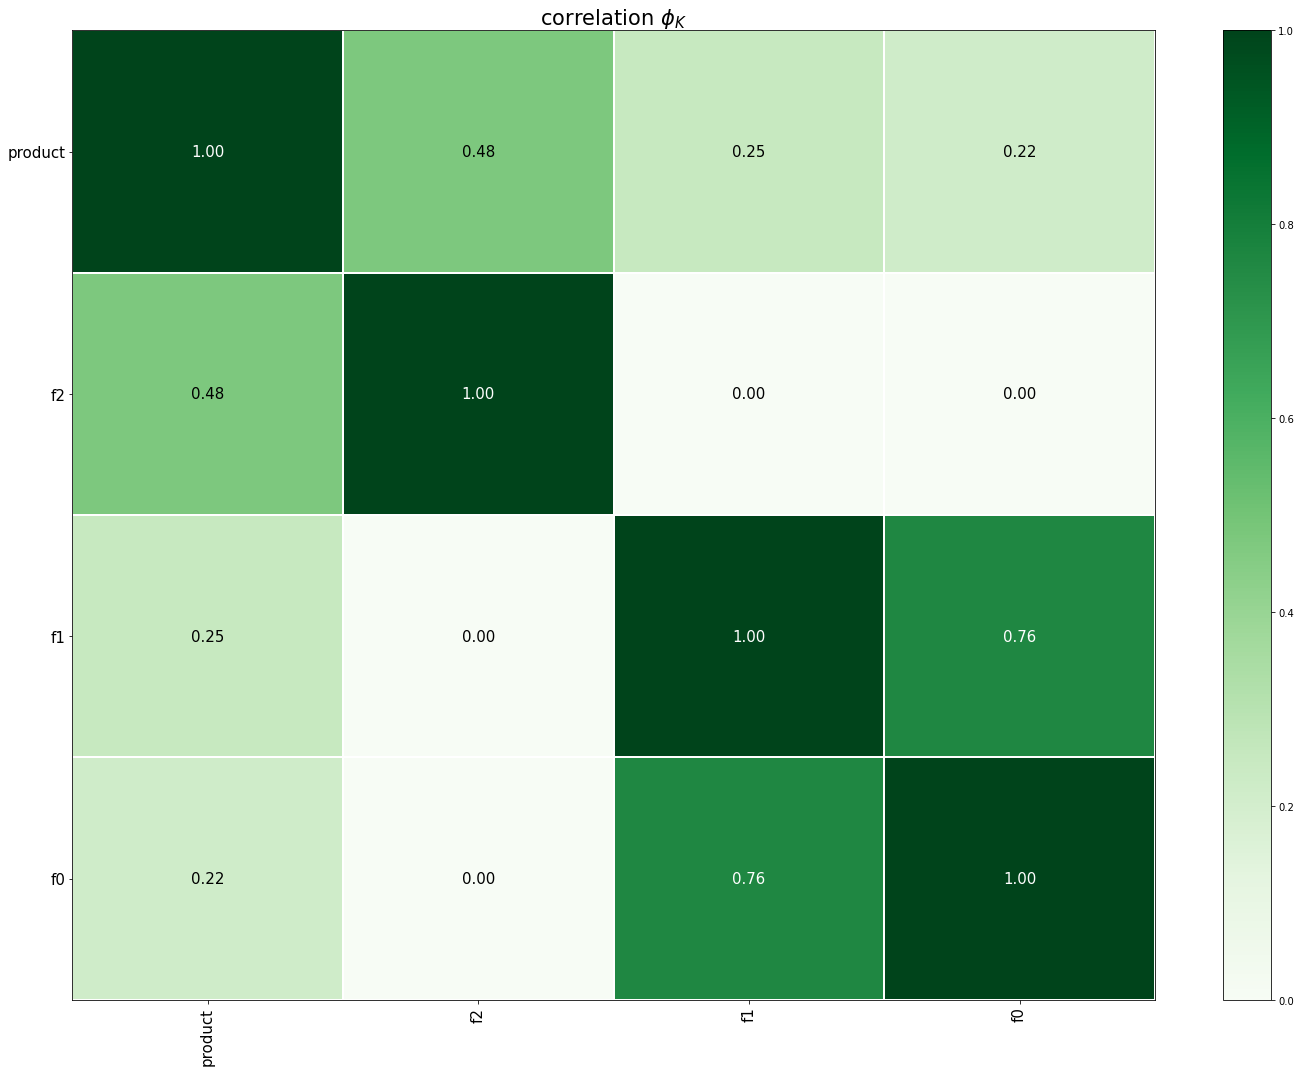

In [29]:
# Функции передаём значения матрицы корреляции phik_overview.values.
# Указываем наименования столбцов x_labels=phik_overview.columns.
# Указываем наименования строк y_labels=phik_overview.index.
# Указываем цвет градиентной отрисовки vmin=0, vmax=1, color_map='Greens'.
# Добавляем заголовок title=r'correlation $\phi_K$'.
# Увеличиваем размер шрифта fontsize_factor=1.5.
# Увеличиваем размер графика figsize=(20, 15).

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [30]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['f0', 'f1', 'f2', 'product']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(geo_data_1.set_index('id'),interval_cols=interval_cols)
print(phik_overview.shape) 

(4, 4)


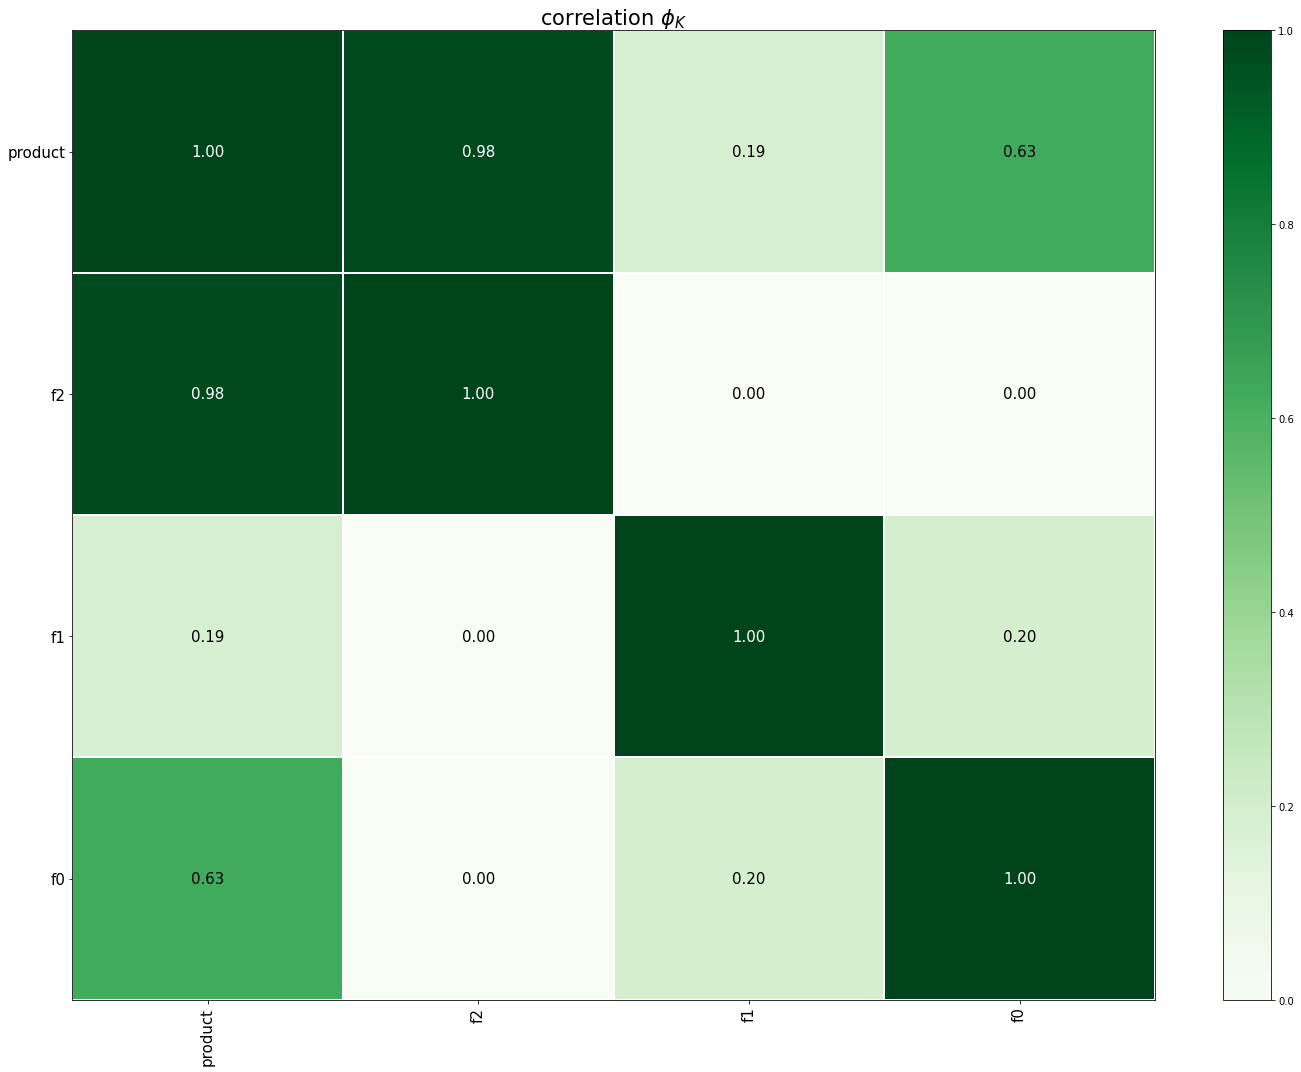

In [31]:
# Функции передаём значения матрицы корреляции phik_overview.values.
# Указываем наименования столбцов x_labels=phik_overview.columns.
# Указываем наименования строк y_labels=phik_overview.index.
# Указываем цвет градиентной отрисовки vmin=0, vmax=1, color_map='Greens'.
# Добавляем заголовок title=r'correlation $\phi_K$'.
# Увеличиваем размер шрифта fontsize_factor=1.5.
# Увеличиваем размер графика figsize=(20, 15).

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

In [32]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['f0', 'f1', 'f2', 'product']

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(geo_data_2.set_index('id'),interval_cols=interval_cols)
print(phik_overview.shape) 

(4, 4)


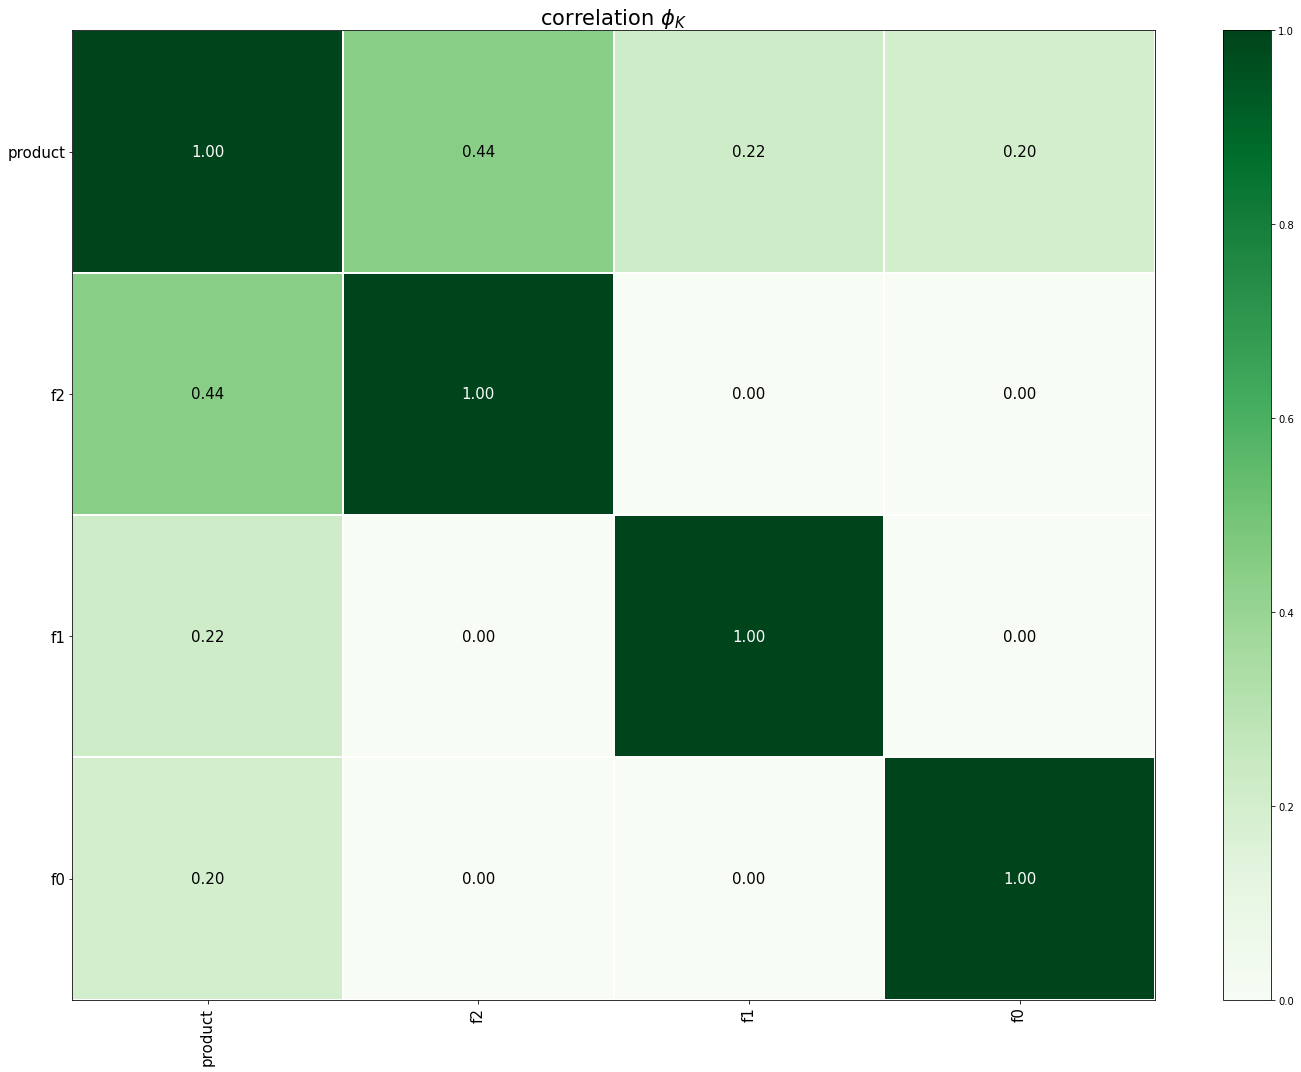

In [33]:
# Функции передаём значения матрицы корреляции phik_overview.values.
# Указываем наименования столбцов x_labels=phik_overview.columns.
# Указываем наименования строк y_labels=phik_overview.index.
# Указываем цвет градиентной отрисовки vmin=0, vmax=1, color_map='Greens'.
# Добавляем заголовок title=r'correlation $\phi_K$'.
# Увеличиваем размер шрифта fontsize_factor=1.5.
# Увеличиваем размер графика figsize=(20, 15).

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Обнаружена мультиколлениарность в geo_data_1 между "f2" и "product", она может помешать обучению нашей модели, поэтому удаляем признак "f2"

In [34]:
# geo_data_1 = geo_data_1.drop(["f2"],axis = 1)

Вывод к шагу 1:
- данные выгружены, исследованы и подготовлены к дальнейшей работе

## Обучение и проверка модели

In [35]:
def func_model_lr(data):
    RANDOM_STATE = 42
    
    X = data.drop(['id', 'product'], axis=1)
    y = data['product']
# разобьем данные на обучающую(X_train, y_train) и валидационную(X_test, y_test) выборки в соотношении 75:25
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
    )
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# инициализация и обучение модели, получение предсказания
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
    predictions = pd.Series(predictions)
# получение значения RMSE
    rmse = mean_squared_error(y_test.reset_index(drop=True), predictions, squared=False)
    
# средний запас предсказанного сырья
    predictions_mean = predictions.sum()/len(predictions)
    
# # вывод полученного значения RMSE, "средний запас предсказанного сырья", предсказаний, эталонных значений 
#     print(rmse)
#     print(predictions_mean)
#     print(predictions)
#     print(y_test)

# Возвращаем все значения которые требуют сохранения 
    return y_test.reset_index(drop=True), predictions, predictions_mean, rmse

In [36]:
y_test_0, predictions_0, predictions_mean_0, rmse_0 = func_model_lr(geo_data_0)
y_test_1, predictions_1, predictions_mean_1, rmse_1 = func_model_lr(geo_data_1)
y_test_2, predictions_2, predictions_mean_2, rmse_2 = func_model_lr(geo_data_2)

In [37]:
print(f'Для региона 0 - средний запас предсказанного сырья: {predictions_mean_0}, полученное значения RMSE: {rmse_0}')
print(f'Для региона 1 - средний запас предсказанного сырья: {predictions_mean_1}, полученное значения RMSE: {rmse_1}')
print(f'Для региона 2 - средний запас предсказанного сырья: {predictions_mean_2}, полученное значения RMSE: {rmse_2}')

Для региона 0 - средний запас предсказанного сырья: 92.39879990657768, полученное значения RMSE: 37.75660035026169
Для региона 1 - средний запас предсказанного сырья: 68.7128780391376, полученное значения RMSE: 0.8902801001028846
Для региона 2 - средний запас предсказанного сырья: 94.77102387765939, полученное значения RMSE: 40.145872311342174


Вывод к шагу 2

- То есть для региона 0 в среднем модель ошибается примерно на 38 тыс. баррелей - средний показатель из всех регионов, при этом средний запас предсказанного сырья: 92 тыс. баррелей

- для региона 1 rmse модели составил меньше 1 тыс. баррелей, что является наилучшим результатом из всех, а средний запас предсказанного сырья: 69 тыс. баррелей

- для региона 2 модель ошибается в среднем примерно на 40 тыс. баррелей, зато средний запас предсказанного сырья: 95 - самый большой обьем из всех

## Подготовка к расчёту прибыли

Введем все необходимые константы (по условию)

Условия задачи:

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. 
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [38]:
ALL_POINTS = 500
BEST_POINTS = 200
BUDGET = 10000000000
BARREL = 450
PER_UNIT_OF_PRODUCT = 450000
PROBABILITY_TRESHHOLD= 0.025

In [39]:
# достаточный объём сырья для безубыточной разработки новой скважины
volume_of_raw = BUDGET/BEST_POINTS/PER_UNIT_OF_PRODUCT 
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {round(volume_of_raw,3)} единицы продукта' )

Достаточный объём сырья для безубыточной разработки новой скважины: 111.111 единицы продукта


Вывод к шагу 3

- К сожалению, во всех трех регионах средний запас предсказанного сырья меньше чем Достаточный объём сырья для безубыточной разработки новой скважины, следовательно есть вероятность того что не все скважины будут безубыточные.

## Расчёт прибыли и рисков 

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

Алгоритм написания функции был представлен в условии задачи, будем пользоваться им: 

- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

In [40]:
# функция для расчета прибыли на 500 разведанных точек.
def profit(y_test, pred, count):
    # сортируем вероятности по убыванию
    preds_sorted = pred.sort_values(ascending=False)
    selected = y_test[preds_sorted.index][:count]
    return PER_UNIT_OF_PRODUCT * selected.sum() - BUDGET

In [41]:
profit_0 = profit(y_test_0, predictions_0, 200)
print('Прибыль по выбранным скважинам и предсказаниям модели региона 0 = {:.2f} руб'.format(profit_0))
profit_1 = profit(y_test_1, predictions_1, 200)
print('Прибыль по выбранным скважинам и предсказаниям модели региона 1 = {:.2f} руб'.format(profit_1))
profit_2 = profit(y_test_2, predictions_2, 200)
print('Прибыль по выбранным скважинам и предсказаниям модели региона 2 = {:.2f} руб'.format(profit_2))

Прибыль по выбранным скважинам и предсказаниям модели региона 0 = 3359141114.46 руб
Прибыль по выбранным скважинам и предсказаниям модели региона 1 = 2415086696.68 руб
Прибыль по выбранным скважинам и предсказаниям модели региона 2 = 2598571759.37 руб


Наибольшая прибыль у региона 0 = 3359141114.46 руб

Посчитаем риски и прибыль для каждого региона по условию:

 - 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 - 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
 - 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

In [42]:
random_state = np.random.RandomState(12345)

def bootstrap_analysis(target_values, predicted_values):
    results = []
    num_losses = 0
    
    for _ in range(1000):
        sampled_target = target_values.sample(replace=True, random_state=random_state, n=500)
        sampled_preds = predicted_values[sampled_target.index]
        profit_value = profit(target_values, sampled_preds, 200)
        
        if profit_value < 0:
            num_losses += 1
            
        results.append(profit_value)
    
    results_series = pd.Series(results)
    lower_bound = results_series.quantile(0.025)
    upper_bound = results_series.quantile(0.975)
    mean_profit = results_series.mean()
    risk_percentage = num_losses / 1000
    
    return mean_profit, lower_bound, upper_bound, risk_percentage

In [43]:
avg_profit_region_0, conf_interval_lower_0, conf_interval_upper_0, loss_percentage_0 = bootstrap_analysis(y_test_0, predictions_0)

# Вывод результатов для региона 0
print('Результаты анализа для региона 0:')
print('Средняя прибыль составляет {:.2f} тыс. руб.'.format(avg_profit_region_0 / 1000))
print('95%-ный доверительный интервал: от {:.2f} до {:.2f} тыс. руб.'.format(conf_interval_lower_0, conf_interval_upper_0))
print('Вероятность убытков: {:.2%}'.format(loss_percentage_0))

Результаты анализа для региона 0:
Средняя прибыль составляет 406278.78 тыс. руб.
95%-ный доверительный интервал: от -117742136.49 до 911737050.75 тыс. руб.
Вероятность убытков: 6.70%


In [44]:
avg_profit_region_1, conf_interval_lower_1, conf_interval_upper_1, loss_percentage_1 = bootstrap_analysis(y_test_1, predictions_1)

# Вывод результатов для региона 0
print('Результаты анализа для региона 1:')
print('Средняя прибыль составляет {:.2f} тыс. руб.'.format(avg_profit_region_1 / 1000))
print('95%-ный доверительный интервал: от {:.2f} до {:.2f} тыс. руб.'.format(conf_interval_lower_1, conf_interval_upper_1))
print('Вероятность убытков: {:.2%}'.format(loss_percentage_1))

Результаты анализа для региона 1:
Средняя прибыль составляет 441504.28 тыс. руб.
95%-ный доверительный интервал: от 35728489.28 до 828006639.00 тыс. руб.
Вероятность убытков: 1.60%


In [45]:
avg_profit_region_2, conf_interval_lower_2, conf_interval_upper_2, loss_percentage_2 = bootstrap_analysis(y_test_2, predictions_2)

# Вывод результатов для региона 0
print('Результаты анализа для региона 2:')
print('Средняя прибыль составляет {:.2f} тыс. руб.'.format(avg_profit_region_2 / 1000))
print('95%-ный доверительный интервал: от {:.2f} до {:.2f} тыс. руб.'.format(conf_interval_lower_2, conf_interval_upper_2))
print('Вероятность убытков: {:.2%}'.format(loss_percentage_2))

Результаты анализа для региона 2:
Средняя прибыль составляет 385213.20 тыс. руб.
95%-ный доверительный интервал: от -164785166.11 до 888206234.20 тыс. руб.
Вероятность убытков: 7.80%


Вывод к шагу 4:

- Был произведен расчёт прибыли по выбранным скважинам и предсказаниям модели, регион с потенциально наибольшей прибылью - регион 1(Средняя прибыль составляет 441504.28 тыс. руб)

- Также были подсчитаны риски и прибыль для каждого региона

По полученным данным были сделаны следующий вывод регион с меньшими убытками и риском, и с наибольшей потенциальной прибылью - РЕГИОН 1 с следующими оценками:

Результаты анализа для региона 1:
- Средняя прибыль составляет 441504.28 тыс. руб.
- 95%-ный доверительный интервал: от 35728489.28 до 828006639.00 тыс. руб.
- Вероятность убытков: 1.60%

ПОЭТОМУ ДЛЯ выбора региона для разработки скважин подходит регион 1, так как данный регион имеет наименьший риск и с потенциально наибольшую прибыль. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

## Общий вывод

В данном проекте была поставлена задача построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для этого были проделаны следующие шаги:

1) Загрузка и подготовка данных - была осуществлена выгрузка, анализ и предобработка данных, проведены исследовательский и корреляционные анализы

2) Обучена и проверена модель для каждого региона

3)  Рассчитан достаточный объём сырья для безубыточной разработки новой скважины и сделан вывод о том, что К сожалению, во всех трех регионах средний запас предсказанного сырья меньше чем Достаточный объём сырья для безубыточной разработки новой скважины, следовательно есть вероятность того что не все скважины будут безубыточные.

4) Были рассчитаны прибыль и риски для каждого из регионов и сделаны выводы о том что регион с наименьшим риском это регион 1

Следовательно,  предложенный регион для разработки скважин - РЕГИОН 1